# Uso de imagenes GOES-ACM

## 1. Impotando librerías requeridas.

El uso de librerías como numpy y pandas para el manejo de matrices de datos es esencial en este trabajo. Adicionalmente se importa el módulo pyplot de matplotlib, con el que se dibujan gráficos y mapas.

### NetCDF

Este es el formato de almacenamiento de datos que se utiliza en GOES-16 y 17. Para leer este tipo de datos se usa la librería netCDF4 de python.

### Mapas y Coordenadas.

Basemap de Matplotlib Toolkits se utiliza para generar mapas en los gráficos, usando diferentes tipos de proyecciones.

Por otro lado, pyproj nos ayuda a pasar de una proyección "geoestacionaria" como la que usa GOES a un sistema de latitud y longitud, con el fin de identificar coordenadas con más facilidad

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from mpl_toolkits.basemap import Basemap
from pyproj import Proj
from netCDF4 import Dataset
import pandas as pd
import GOES

# 2. Cargando datos de imagen

A continuación descargamos la imagen para este ejemplo. En éste caso usaremos la una imagen de nivel dos que nos entrega una máscara de nubes

In [10]:
files = GOES.download('goes16','ABI-L2-ACMF',DateTimeIni='20200101-000000',DateTimeFin='20200101-000900')
print(files)

Files:
  OR_ABI-L2-ACMF-M6_G16_s20200010000216_e20200010009524_c20200010010356.nc 100% 2.0MB 1s
['OR_ABI-L2-ACMF-M6_G16_s20200010000216_e20200010009524_c20200010010356.nc']


In [11]:
im = files[0]

In [12]:
# Podemos extraer la fecha y hora del nombre de la imagen

b_time = im[23:34]
year = int(b_time[:4])
day = (pd.to_datetime('%d-01-01'%year) + 
       pd.to_timedelta(int(b_time[4:7])-1,unit='d'))
hour = int(b_time[7:9])
minuts = int(b_time[-2:])
ffhh = day+pd.to_timedelta(hour,unit='h')+pd.to_timedelta(minuts,unit='m')

print('Fecha y hora:')
print(ffhh)

Fecha y hora:
2020-01-01 00:00:00


Vemos que esta imagen fue tomada el primero de enero de 2019 a las 0 horas (UTC). Ésto se puede apreciar en el nombre de la imagen.

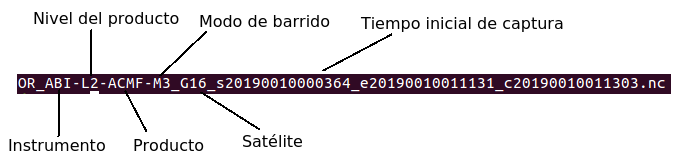

Los primeros 4 dijitos en la cadena que representa el tiempo corresponden al año (2019 en este caso). Los tres siguientes son el número de día del año (001 para ésta), que va desde 1 hasta 365. Los dos siguientes son la hora del día (00), y los dos que siguen los minutos (00).

In [13]:
dataset = Dataset(im) #Ahora leemos la imagen usando el comando Dataset de netCDF4

Ahora, podemos ver los nombres de las variablesa guardadas en nuestro dataset

In [14]:
dataset.variables.keys()

dict_keys(['BCM', 'DQF', 't', 'y', 'x', 'time_bounds', 'goes_imager_projection', 'y_image', 'y_image_bounds', 'x_image', 'x_image_bounds', 'nominal_satellite_subpoint_lat', 'nominal_satellite_subpoint_lon', 'nominal_satellite_height', 'geospatial_lat_lon_extent', 'total_number_of_cloud_mask_points', 'number_of_clear_pixels', 'number_of_probably_clear_pixels', 'number_of_probably_cloudy_pixels', 'number_of_cloudy_pixels', 'percent_clear_pixels', 'percent_probably_clear_pixels', 'percent_probably_cloudy_pixels', 'percent_cloudy_pixels', 'percent_terminator_pixels', 'min_obs_modeled_diff_RTM_BT_comparison_bands_all_sky', 'max_obs_modeled_diff_RTM_BT_comparison_bands_all_sky', 'mean_obs_modeled_diff_RTM_BT_comparison_bands_all_sky', 'std_dev_obs_modeled_diff_RTM_BT_comparison_bands_all_sky', 'min_obs_modeled_diff_RTM_BT_comparison_bands_clear_sky', 'max_obs_modeled_diff_RTM_BT_comparison_bands_clear_sky', 'mean_obs_modeled_diff_RTM_BT_comparison_bands_clear_sky', 'std_dev_obs_modeled_diff_

Puede explorar cada variable usando el siguiente comando:

In [15]:
dataset.variables['BCM']

<class 'netCDF4._netCDF4.Variable'>
int8 BCM(y, x)
    _FillValue: -1
    long_name: ABI L2+ Clear Sky Mask
    standard_name: cloud_binary_mask
    _Unsigned: true
    valid_range: [0 1]
    units: 1
    resolution: y: 0.000056 rad x: 0.000056 rad
    coordinates: retrieval_local_zenith_angle quantitative_local_zenith_angle retrieval_solar_zenith_angle t y x
    grid_mapping: goes_imager_projection
    cell_methods: retrieval_local_zenith_angle: point (good or degraded quality pixel produced) quantitative_local_zenith_angle: point (good quality pixel produced) retrieval_solar_zenith_angle: point (good quality pixel produced) t: point area: point
    flag_values: [0 1]
    flag_meanings: clear_or_probably_clear cloudy_or_probably_cloudy
    ancillary_variables: DQF
    clear_pixel_definition: no cloud detected and failed a test for high values of spatial heterogeneity
    probably_clear_pixel_definition: no cloud detected but passed a test for high values of spatial heterogeneity and o

En el anterior ejemplo se muestra la información de la variable 'BCM', que corresponde a lo valores de la máscara, o de la imagen como tal, en este caso. Allí podemos ver que esta cantidad en particular toma valores de 0 ó 1 para cada pixel de la imagen, siendo 0 cuando está despejado y 1 cuando está nublado. Se puede visualizar también la resolución en radianes, el tamaño de la imagen, entre otras cosas.

A continuación, crearemos un arreglo con máscara con el tamaño de la imagen (5424 X 5424) que contenga la información de la misma.

In [16]:
cs = dataset.variables['BCM'][:]
cs

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=255,
  dtype=uint8)

Vemos que se tienen varios valores "vaciós" que corresponden a los bordes de la imagen. Estos están señalados por un flag definido en el arreglo que se muestra como "mask", los cuales son "llenados" con un valor de 255 en caso de que sea "verdadero" (True). Veamos esto usando arreglos de numpy.

In [17]:
np.array(cs)

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [18]:
np.array(cs)[1000][1000:1020]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=uint8)

Ahora, extraemos otras cantidades importantes de la imagen.

In [19]:
# Altura de la órbita del satélite
sat_h= dataset.variables['goes_imager_projection'].perspective_point_height

# Longitud geográfica de la órbita del satélite
sat_lon = dataset.variables['goes_imager_projection'].longitude_of_projection_origin

# Dirección en que se hace el barrido
sat_sweep = dataset.variables['goes_imager_projection'].sweep_angle_axis

# Leo las coordenadas del satélite. 
# Son generadas con una proyección geo-estacionaria

X = dataset.variables['x'][:]
Y = dataset.variables['y'][:]

## 2. Visualización de la imagen

Se utilizan herramientas de Matplotlib para visualizar la imagen en un mapa, teniendo en cuenta las variables definidas anteriormente asociadas a la posición del satélite y al tipo de proyección.

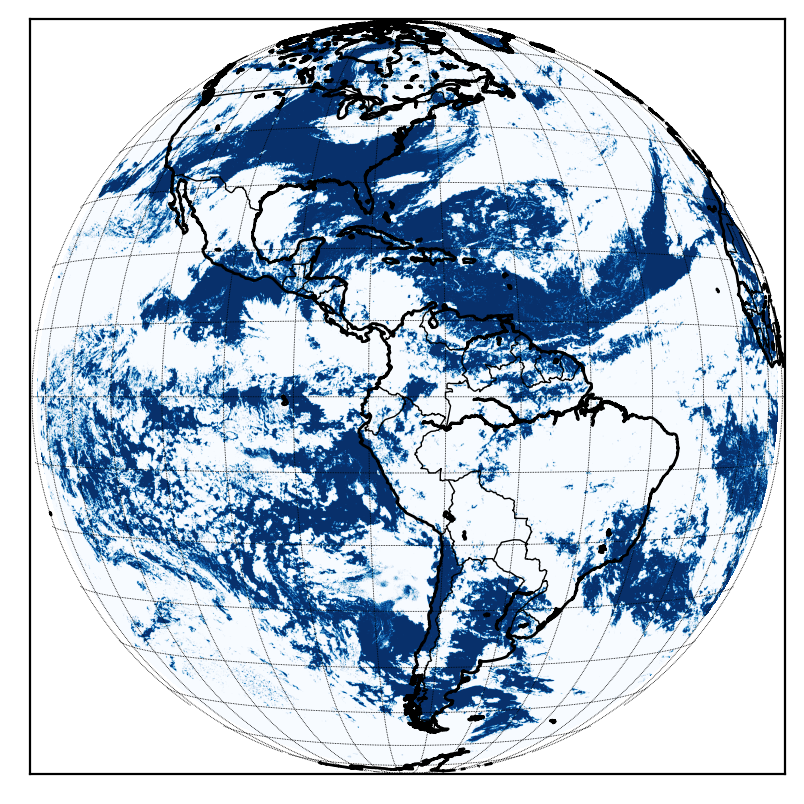

In [20]:
fig = plt.figure(figsize=(5,5),dpi=200)
# Este es el mapa. 
# Note que se multiplican las coordenadas por la altura del satélite
m = Basemap(resolution='l', projection='geos', lon_0=sat_lon,
            llcrnrx=X.min()*sat_h, llcrnry=Y.min()*sat_h, 
            urcrnrx=X.max()*sat_h, urcrnry=Y.max()*sat_h, rsphere=(6378137.00,6356752.3142))
im = m.imshow(cs,cmap='Blues_r',origin='upper')
m.drawcountries()
m.drawcoastlines()
m.drawparallels(np.arange(-90.0, 90.0, 10.0), linewidth=0.3, color='black')
m.drawmeridians(np.arange(0.0, 360.0, 10.0), linewidth=0.3, color='black')
#plt.colorbar()
plt.show()

En la anterior imagen, el blanco representa los unos (1s), es decir las nubes detectadas, mientras el azul representa los pixeles despejados.

## 3. Seleccionar un sitio dadas sus coordenadas

In [21]:
# Creamos un objeto (función) que nos permite hacer proyecciones dados
# los parámetros de la órbita del satélite
p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)

In [22]:
# Esquina inferior izquierda del "recuadro" que queremos estudiar
xmin,ymin = p(-90,-15)/sat_h
# Esquina superior derecha
xmax,ymax = p(-60,15)/sat_h

sel_x = np.where((X>=xmin) & (X<=xmax))
sel_y = np.where((Y>=ymin) & (Y<=ymax))
x_col = X[sel_x]
y_col = X[sel_y]
print('Tamaño de la imagen "recortada":',len(y_col),'X',len(x_col))

Tamaño de la imagen "recortada": 1616 X 1570


In [23]:
# Asignamos los datos de la imagen recortada a una nueva variable
cs_cut= cs[sel_y[0].min():sel_y[0].max()+1,sel_x[0].min():sel_x[0].max()+1]

### a. Visualización de la nueva imagen

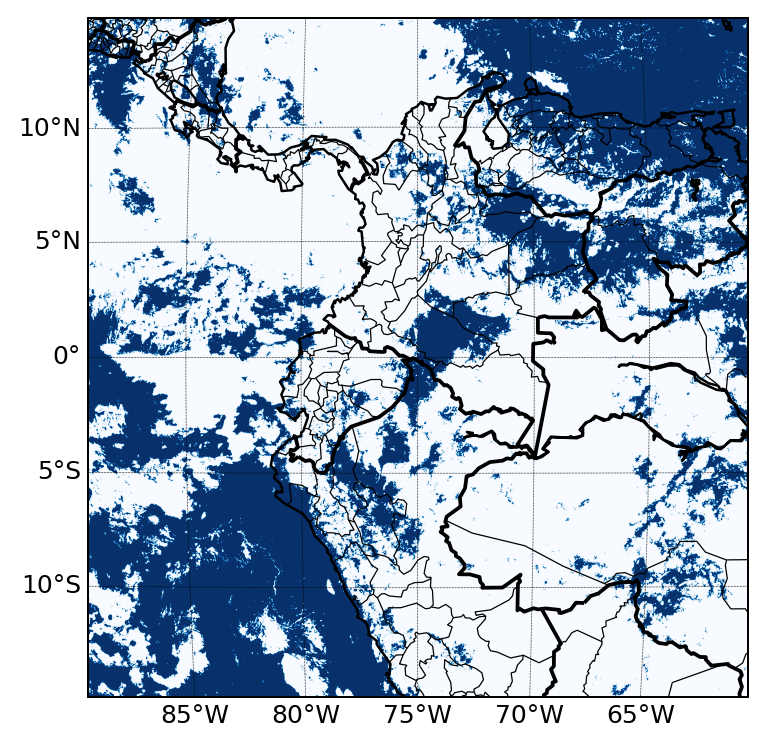

In [24]:
fig = plt.figure(figsize=(5,5),dpi=180)
m = Basemap(resolution='l', projection='geos', lon_0=sat_lon,
            llcrnrx=x_col.min()*sat_h, llcrnry=y_col.min()*sat_h, 
            urcrnrx=x_col.max()*sat_h, urcrnry=y_col.max()*sat_h, rsphere=(6378137.00,6356752.3142))
im = m.imshow(cs_cut,origin='upper',cmap='Blues_r')
m.drawcoastlines()
m.drawcountries(linewidth=1.5)
m.drawstates()
m.drawparallels(np.arange(-10,15,5),linewidth=0.3, 
                color='black',labels=[True,False,False,True])
m.drawmeridians(np.arange(-85,-60,5),linewidth=0.3, 
                color='black',labels=[True,False,False,True])
plt.show()
plt.close()

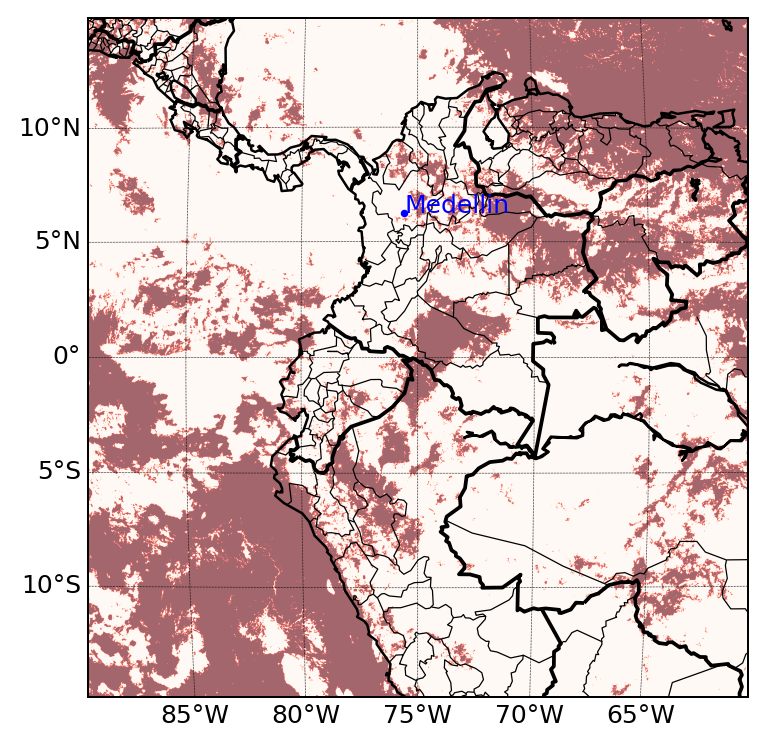

In [26]:
# Podemos, por ejemplo, cambiar la paleta de colores 
# y marcar un punto sobre el mapa:

fig = plt.figure(figsize=(5,5),dpi=180)
m = Basemap(resolution='l', projection='geos', lon_0=sat_lon,
            llcrnrx=x_col.min()*sat_h, llcrnry=y_col.min()*sat_h, 
            urcrnrx=x_col.max()*sat_h, urcrnry=y_col.max()*sat_h, rsphere=(6378137.00,6356752.3142))
im = m.imshow(cs_cut,origin='upper',cmap='Reds_r',alpha=0.6)
m.drawcoastlines()
m.drawcountries(linewidth=1.5)
m.drawstates()
m.drawparallels(np.arange(-10,15,5),linewidth=0.3, 
                color='black',labels=[True,False,False,True])
m.drawmeridians(np.arange(-85,-60,5),linewidth=0.3, 
                color='black',labels=[True,False,False,True])

lat = 6.244747 # latitud
lon = -75.574828 # longitud

x,y=m(lon,lat)
m.plot(x,y,'bo',markersize=2)
plt.text(x,y,'Medellin',fontsize=10,color='blue')

plt.show()
plt.close()

In [27]:
# Para pasar de cualquier coordenadas en lon-lat 
# a las coordenadas proyectadas

p(lon,lat)/sat_h

# Tambien se puede hacer en la otra dirección
# (siempre multiplicando por la altura)

xm = -0.00177533 * sat_h
ym = 0.01923531 * sat_h

p(xm,ym,inverse=True)

# Y para conocer las coordenadas del pixel más cercano

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

xc = find_nearest(X,xm/sat_h)*sat_h
yc = find_nearest(Y,ym/sat_h)*sat_h

print(p(xc,yc,inverse=True))

(-75.5711578588535, 6.244972555761528)
